# Purpose
The purpose of this file is to clean and manage data the 2008-2010 Medicare Claims Synthetic Public Use Files (SynPUFs).

# Setup
First, we'll import the packages we'll need for data management tasks.

In [38]:
# import packages
import pandas as pd
import numpy as np

# Adjust pandas display settings to show all rows
pd.set_option('display.max_rows', None)

# Load data and codebook

Next, we will load the Beneficiary Summary files into Python. Each file is separated by year (2008, 2009, 2010).

In [32]:
# load the Beneficiary Summary files
demo_08 = pd.read_csv("data/2008_Beneficiary_Summary_File_Sample_1.csv")
demo_09 = pd.read_csv("data/2009_Beneficiary_Summary_File_Sample_1.csv")
demo_10 = pd.read_csv("data/2010_Beneficiary_Summary_File_Sample_1.csv")

Then we will load in the Beneficiary Summary File **codebook**, which will be used to efficiently rename variable (column) names into names that are more easily readable.

In [ ]:
# load the codebook file
codebook_demo = pd.read_excel("codebooks/Codebook_Beneficiary_Summary_File.xlsx",
                              sheet_name = "Codebook")

In [41]:
# create a function to use values from the codebook to rename columns
# we will use the 'old_name' column (original column names) to rename the columns in the dataframes
def rename_columns(df, codebook):
    # Create a mapping from old names to new names
    name_mapping = dict(zip(codebook['old_name'], 
                            codebook['new_name']))
    # Rename the columns in the dataframe
    df.rename(columns=name_mapping, 
              inplace=True)
    return df


# run the function on each data frame
demo_08 = rename_columns(df = demo_08, 
                         codebook = codebook_demo)
demo_09 = rename_columns(df = demo_09, 
                         codebook = codebook_demo)
demo_10 = rename_columns(df = demo_10, 
                         codebook = codebook_demo)

Now we'll examine summary information about the datasets, including the number of rows/columns, the data types of each variable, and the first few rows of each dataset.

In [35]:
# Create a data dictionary with the Beneficiary Summary File names
datasets = {
    "2008 Beneficiary Summary File": demo_08,
    "2009 Beneficiary Summary File": demo_09,
    "2010 Beneficiary Summary File": demo_10
}

# Loop through each Beneficary Summary file to summarize the number of rows/columns.
for name, data in datasets.items():
    rows, cols = data.shape
    print(f"Dataset name: {name}")
    print(f"Number of rows: {rows}")
    print(f"Number of columns: {cols}")
    print("Variable (column) names:", data.columns.tolist())
    print("") # add an extra space between output to improve clarity

Dataset name: 2008 Beneficiary Summary File
Number of rows: 116352
Number of columns: 32
Variable (column) names: ['person_id', 'birthdate', 'deathdate', 'sex', 'race', 'end_stage_renal_disease', 'state_code', 'county_code', 'months_part_a_coverage', 'months_part_b_coverage', 'months_hmo_coverage', 'months_part_d_coverage', 'dementia', 'heart_failure', 'kidney_disease', 'cancer', 'copd', 'depression', 'diabetes', 'ischemic_heart_disease', 'osteoporosis', 'arthritis', 'stroke', 'annual_inpatient_reimbursement', 'annual_inpatient_responsibility', 'annual_inpatient_primary_payer_reimbursement', 'annual_outpatient_reimbursement', 'annual_outpatient_responsibility', 'annual_outpatient_primary_payer_reimbursement', 'annual_carrier_reimbursement', 'annual_carrier_responsibility', 'annual_carrier_primary_payer_responsibility']

Dataset name: 2009 Beneficiary Summary File
Number of rows: 114538
Number of columns: 32
Variable (column) names: ['person_id', 'birthdate', 'deathdate', 'sex', 'race',

Now we want to combine the three Beneficiary Summary files into a single file.

In [36]:
# first, create an indicator for the year
for name, data in datasets.items():
    # extract the year value as the first 4 digits
    data["year"] = name[0:4]

# check to make sure the values were assigned correctly in each data frame
print(demo_08['year'].value_counts())
print(demo_09['year'].value_counts())
print(demo_10['year'].value_counts())

year
2008    116352
Name: count, dtype: int64
year
2009    114538
Name: count, dtype: int64
year
2010    112754
Name: count, dtype: int64


Finally, we'll merge the three data frames into one so we can work with all of the data at once.

In [39]:
# merge the dataframes by concatenating them
merged_demo = pd.concat([demo_08, demo_09, demo_10], 
                        ignore_index=True)

# examine the merged data
print("-- Merged DataFrame --")
print(f"Number of rows: {merged_demo.shape[0]}")
print(f"Number of columns: {merged_demo.shape[1]}")
print("Data types for each column:")
print(merged_demo.dtypes)

-- Merged DataFrame --
Number of rows: 343644
Number of columns: 33
Data types for each column:
person_id                                         object
birthdate                                          int64
deathdate                                        float64
sex                                                int64
race                                               int64
end_stage_renal_disease                           object
state_code                                         int64
county_code                                        int64
months_part_a_coverage                             int64
months_part_b_coverage                             int64
months_hmo_coverage                                int64
months_part_d_coverage                             int64
dementia                                           int64
heart_failure                                      int64
kidney_disease                                     int64
cancer                                           

# Variable recoding

First, we'll merge the US state name and abbreviation by the US state FIPS code that was already included in the Beneficiary Summary Files.

In [ ]:
# load the US State FIPS code file
fips = pd.read_excel("codebooks/Codebook_Beneficiary_Summary_File.xlsx",
                     sheet_name = "State FIPS Codes")

# merge the `fips` data frame with the merged data
merged_demo = pd.merge(merged_demo, 
                       fips, 
                       how='left', 
                       left_on='state_code', 
                       right_on='state_code')

# summarize the US states in the merged data in a table
state_summary = merged_demo['state_name'].value_counts()
#state_summary.columns = ['State Name', 'Count'] 
# sort the summary by count in descending order
#state_summary = state_summary.sort_values(by='Count', ascending=False)
# display the state summary
print("-- State Summary --")
print(state_summary)


MergeError: Passing 'suffixes' which cause duplicate columns {'state_abbrev_x', 'state_name_x'} is not allowed.

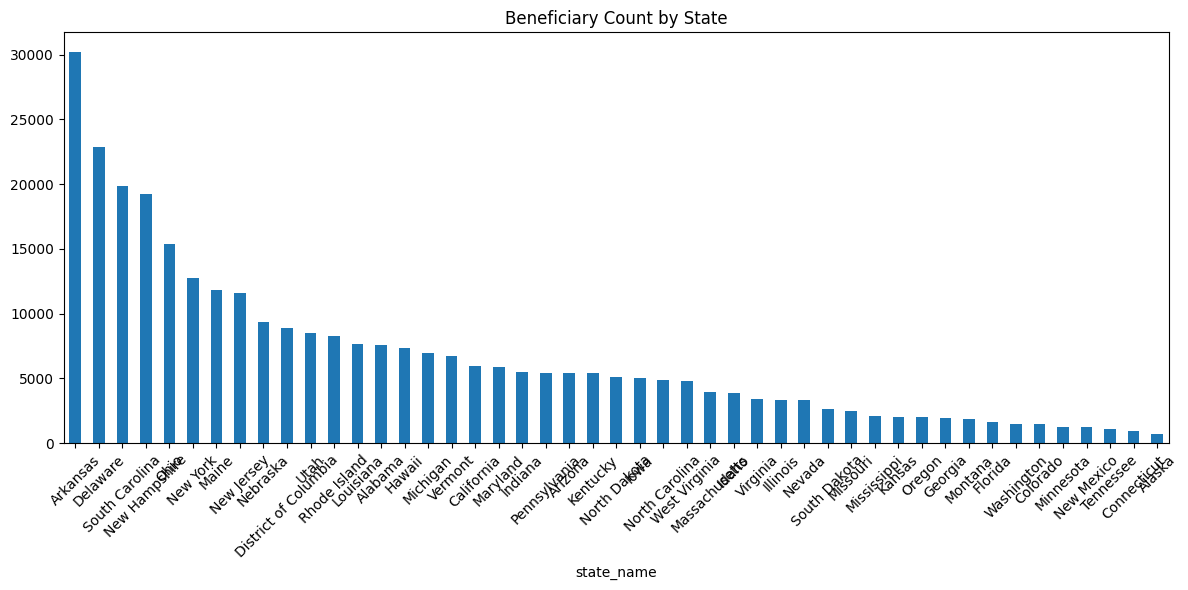

In [53]:
merged_demo['state_name'].value_counts().plot(kind='bar', figsize=(12, 6), title='Beneficiary Count by State')
import matplotlib.pyplot as plt 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()      

Next, we'll examine the value counts for the categorical variables:
*   Race/ethnicity
*   Sex
*   US State (FIPS code)

In [14]:
categorical_vars = {
    "BENE_RACE_CD": "Race/ethnicity",
    "BENE_SEX_IDENT_CD": "Sex",
    "SP_STATE_CODE": "US State FIPS Code"
}

for var, label in categorical_vars.items():
    summary = demo_08[var].value_counts().sort_index()  # sort by category label
    print(f"{label} ({var}):")
    print(summary)
    print("\n")

Race/ethnicity (BENE_RACE_CD):
BENE_RACE_CD
1    96349
2    12343
3     4931
5     2729
Name: count, dtype: int64


Sex (BENE_SEX_IDENT_CD):
BENE_SEX_IDENT_CD
1    52005
2    64347
Name: count, dtype: int64


US State FIPS Code (SP_STATE_CODE):
SP_STATE_CODE
1      2570
2       244
3      2325
4      1851
5     10224
6      2012
7      1473
8       493
9       310
10     7745
11     3012
12      544
13      675
14     4277
15     2497
16     1317
17     1142
18     1864
19     1715
20      692
21     1837
22     2587
23     4012
24     1982
25     1331
26     2378
27      429
28      713
29      842
30      644
31     3176
32     1119
33     6510
34     3935
35      420
36     4329
37     1663
38     1725
39     5199
41      674
42     1848
43      419
44     2803
45     6703
46      889
47      374
49     2895
50     2282
51     1152
52     2371
53      501
54     1628
Name: count, dtype: int64


